# Traveling Salesman Problem

In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


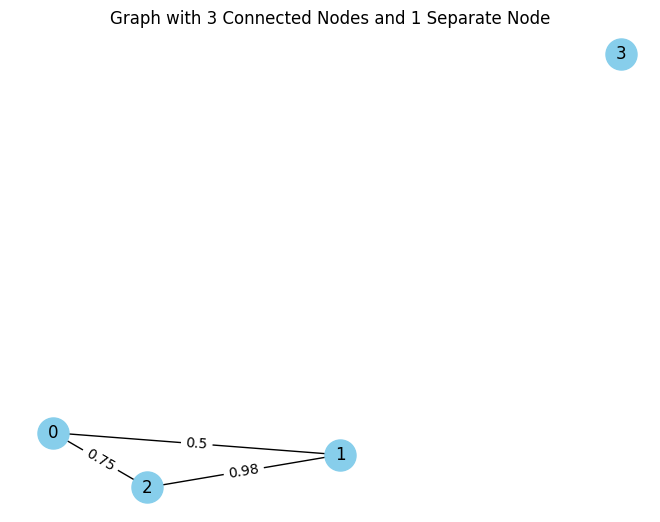

In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

grid = [[0.5,0.98],
        [0.24,0.75]]

# Define the number of nodes
num_nodes = len(grid) * len(grid[0])

# Initialize an empty adjacency matrix
w = np.zeros((num_nodes, num_nodes))

# Manually set the connections based on the specification
# Connect node 0 with node 1
w[0, 1] = grid[0][1]  # Using grid values for weights
w[1, 0] = grid[0][0]
w[0, 2] = grid[1][1]

# Connect node 1 with node 2
w[1, 2] = grid[1][0]
w[2, 1] = grid[0][1]

# Node 3 remains separate, so no connections are set for it

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(w)

# Function to draw the graph
def draw_graph(graph):
    pos = nx.spring_layout(graph)  # positions for all nodes
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=500)
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.title("Graph with 3 Connected Nodes and 1 Separate Node")
    plt.show()

# Draw the graph
draw_graph(G)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Mapping to the Ising problem

Qiskit optimization provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.


In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



Since the problem was cast to a minimization problem, the solution of $-4$ corresponds to the optimum.

## Traveling Salesman Problem

In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time. 

The problem derives its importance from its "hardness" and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.
 
The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest *Hamiltonian cycle* that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and $p$ represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summands run over 0,1,...N-1)

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j) \notin E$ (not connected in the graph). The form of this penalty is 

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$ 

where it is assumed the boundary condition of the Hamiltonian cycles $(p=N)\equiv (p=0)$. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

Putting this all together in a single objective function to be minimized, we get the following:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ is a free parameter. One needs to ensure that $A$ is large enough so that these constraints are respected. One way to do this is to choose $A$ such that $A > \mathrm{max}(w_{ij})$.

Once again, it is easy to map the problem in this form to a quantum computer, and the solution will be found by minimizing a Ising Hamiltonian. 

In [11]:
# Generating a graph of 3 nodes
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import seed, randint

# Function to generate a random TSP graph
def random_tsp():
    #seed(seed_value)
    G = nx.Graph()
    for i in range(n):
        for j in range(i + 1, n):
            # Random weight between 1 and 10
            weight = randint(1, 10)
            G.add_edge(i, j, weight=weight)
    return G

# Generate a TSP instance with 3 nodes
n = 3
tsp_graph = random_tsp()

# Create adjacency matrix
adj_matrix = nx.to_numpy_array(tsp_graph)
print("Distance matrix:\n", adj_matrix)

Distance matrix:
 [[0. 9. 8.]
 [9. 0. 5.]
 [8. 5. 0.]]


Traceback (most recent call last):
  Cell In[19], line 8
    draw_graph(G, colors, pos)
  Cell In[19], line 3 in draw_graph
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
  File /opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:304 in draw_networkx
    draw_networkx_nodes(G, pos, **node_kwds)
  File /opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:429 in draw_networkx_nodes
    xy = np.asarray([pos[v] for v in nodelist])
  File /opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:429 in <listcomp>
    xy = np.asarray([pos[v] for v in nodelist])
IndexError: list index out of range

Use %tb to get the full traceback.


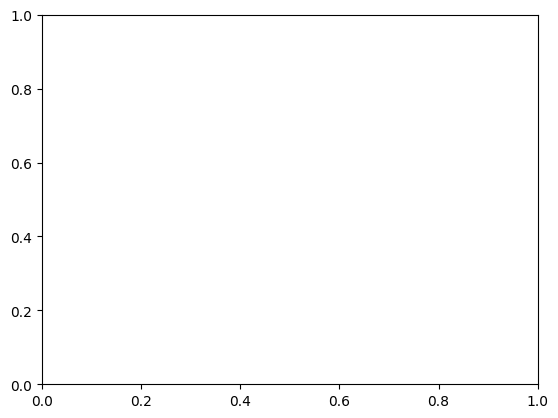

In [19]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

### Brute force approach

In [5]:
from itertools import permutations

n = 4
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(G, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

Traceback (most recent call last):
  Cell In[5], line 22
    best_distance, best_order = brute_force_tsp(G, n)
  Cell In[5], line 11 in brute_force_tsp
    distance = distance + w[j, pre_j]
  File /opt/conda/lib/python3.10/site-packages/networkx/classes/graph.py:513 in __getitem__
    return self.adj[n]
  File /opt/conda/lib/python3.10/site-packages/networkx/classes/coreviews.py:81 in __getitem__
    return AtlasView(self._atlas[name])
KeyError: (1, 0)

Use %tb to get the full traceback.


In [31]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### Mapping to the Ising problem

In [32]:
n = 3
tsp = Tsp.create_random_instance(n, seed=123)
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [33]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

In [34]:
from qiskit_optimization.converters import QuadraticProgramToQubo
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost 

In [35]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, G))
draw_tsp_solution(tsp.graph, z, colors, pos)

energy: -7379.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
Traceback (most recent call last):
  Cell In[35], line 11
    print("solution objective:", tsp.tsp_value(z, G))
  File /opt/conda/lib/python3.10/site-packages/qiskit_optimization/applications/tsp.py:214 in tsp_value
    ret += adj_matrix[z[i], z[i + 1]]
  File /opt/conda/lib/python3.10/site-packages/networkx/classes/graph.py:513 in __getitem__
    return self.adj[n]
  File /opt/conda/lib/python3.10/site-packages/networkx/classes/coreviews.py:81 in __getitem__
    return AtlasView(self._atlas[name])
KeyError: (0, 1)

Use %tb to get the full traceback.


### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [36]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -7326.02469952184
time: 27.482500314712524
feasible: True
solution: [1, 2, 0]
solution objective: 22.0


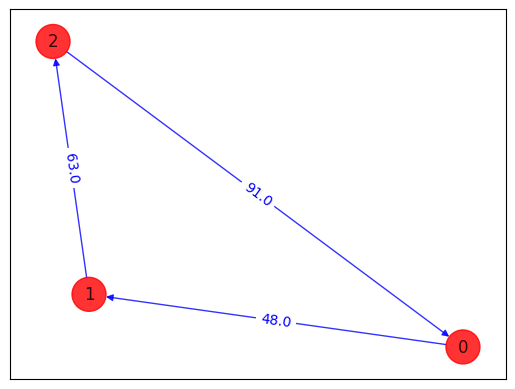

In [37]:
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [38]:
algorithm_globals.random_seed = 123
seed = 10598

objective function value: 202.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0
status: SUCCESS
solution: [1, 2, 0]
solution objective: 22.0


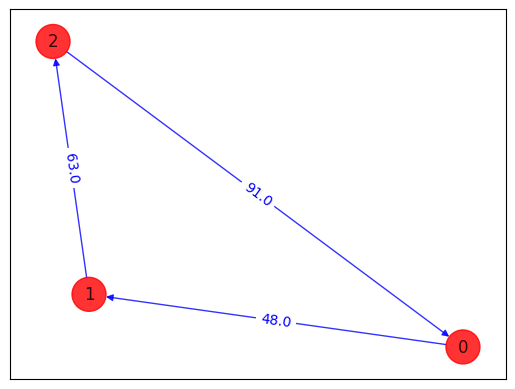

In [39]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [22]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright